<a href="https://colab.research.google.com/github/AlbertMdz/T-cnicas_Algor-tmicas/blob/master/SVM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

In [0]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

In [0]:
def plot_data(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""

        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)

        grid = [[decision_function(model.alphas, model.y, 
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap='winter')
        
        return grid, ax

def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)

        grid = [[decision_function(model.alphas, model.y, 
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap='winter', lw=0, alpha=0.5)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap='winter', lw=1, edgecolors='k')
        
        return grid, ax

#**Kernels**

In [0]:
def linear_kernel(x, y, b=1,degree=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    
    return (x @ y.T + b)**degree # Note the @ operator for matrix multiplication

def polynomial_kernel(x, y, b=1,degree=2):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    
    return (x @ y.T + b)**degree # Note the @ operator for matrix multiplication

def gaussian_kernel(x, y, sigma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel width parameter `sigma` (set to 1 by default)."""
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

#**Dual Problem**

Using Lagrange duality, the optimization problem can be reformulated into the dual form

$max_α \quad W(α)=∑^{m}_{i=1}α_{i}−\frac{1}{2}∑_{i,j=1}^{m}y^{(i)}y^{(j)}α_iα_j⟨x^{(i)},x^{(j)}⟩$

This problem is also subject to the following two constraints:

$0≤α_i≤C,i=1,...,m$

$∑_{i=1}^{m}α_{i}y^{(i)}=0$

Where

$m$ is the number of training examples

$x^{(i)}$ is the $i$-th training example feature vector

$⟨x^{(i)},x^{(j)}⟩$ represents the inner product of the $x^{(i)}$ and $x^{(j)}$ feature vectors

$y^{(i)}$ is the class for the $i$-th training example

$α_i$ is the Lagrange multiplier associated with the $i$-th training example

$C$ is a regularization parameter (larger values introduce less regularization)

Funcion de decision

$f(x)=∑_{i=1}^{m}α_{i}⟨x^{(i)},x⟩+b$

In [0]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""
    
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))

# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

#**Sequential minimal optimization** (**SMO** algorithm)

The three functions used to train our model are <strong>take_step()</strong>, <strong>examine_example()</strong>, and <strong>train()</strong>. These are structured to work as follows:
<ul>

<li> The <strong>train()</strong> function implements selection of the first $α$ to optimize via the first choice heuristic and passes this value to <strong>examine_example()</strong>.</li>

<li>Then <strong>examine_example()</strong> implements the second choice heuristic to choose the second $α$ to optimize, and passes the index of both $α$ values to <strong>take_step()</strong>. </li>

<li>Finally <strong>take_step()</strong> carries out the meat of the calculations and computes the two new α values, a new threshold $b$, and updates the error cache. </li>

</ul>
The <strong>train()</strong> function uses a while loop to iterate through the $α$ values in a few different ways until no more optimizations can be made, at which point it returns the optimized α vector (embedded in an SMOModel object).

In [0]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [0]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [0]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

# **Ejemplo 5** (Diapositivas de la clase)

In [0]:
X_train = np.array([(-1,-1),(1,-1),(-1,1),(1,1)])
y = np.array([-1,-1,-1,1])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

In [0]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

In [0]:
output = train(model)
output.alphas[output.alphas > 0]

array([0.5, 0.5, 1. ])

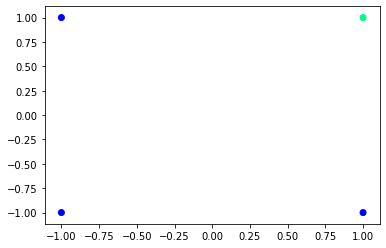

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_data(output, ax)

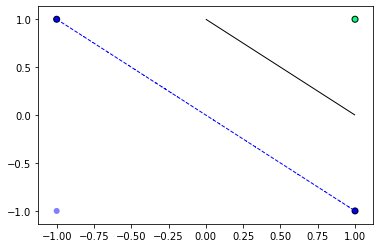

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

# **Ejemplo** (Diapositivas)

In [0]:
X_train = np.array([(1,0),(2,0),(4,0),(5,0),(6,0)])
y = np.array([1,1,-1,-1,1])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

In [0]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, polynomial_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

In [0]:
output = train(model)
output.alphas[output.alphas > 0]

array([0.93752443, 2.82869116, 1.89116673])

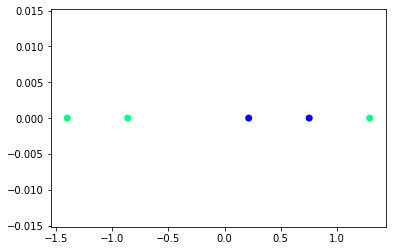

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_data(output, ax)

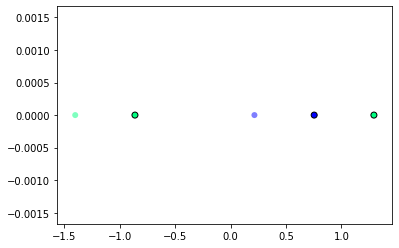

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

# **Ejemplo** (Datos aleatorios)

In [0]:
X_train, y = make_blobs(n_samples=3000, centers=2, n_features=2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [0]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

In [0]:
output = train(model)
output.alphas[output.alphas > 0]

array([0.02329348, 1.03294193, 1.00964845])

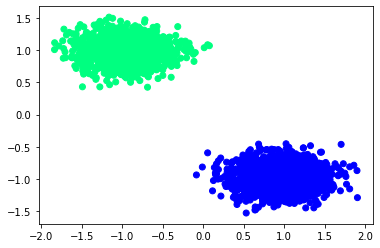

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_data(output, ax)

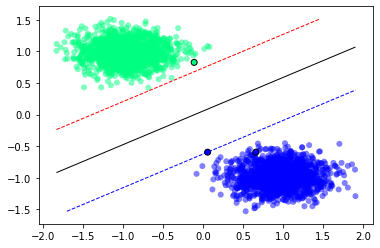

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [0]:
# Add an outlier
X_outlier = np.append(X_train_scaled, [0.1, 0.1])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = np.append(y, 1)

In [0]:
# Set model parameters and initial values
C = 1000.0
m = len(X_outlier)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

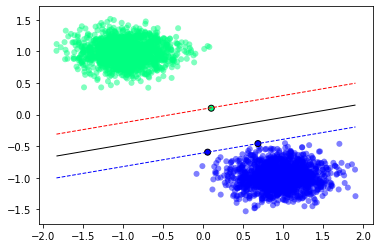

In [0]:
output = train(model)
output.alphas[output.alphas > 0]
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

# **Ejemplo** (Kernel Gaussiano)

In [0]:
X_train, y = make_circles(n_samples=500, noise=0.1,
                          factor=0.1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [0]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

In [0]:
output = train(model)
output.alphas[output.alphas > 0]

array([1.00000000e+00, 8.60268390e-01, 3.99752883e-02, 1.00000000e+00,
       1.38777878e-17, 1.00000000e+00, 2.39055044e-01, 6.25997996e-01,
       6.67819008e-01, 5.23931841e-01, 1.04083409e-17, 1.00000000e+00,
       1.00000000e+00, 3.43743511e-01, 5.26961418e-01, 1.89620302e-01,
       1.00000000e+00, 6.33871099e-01, 1.00000000e+00])

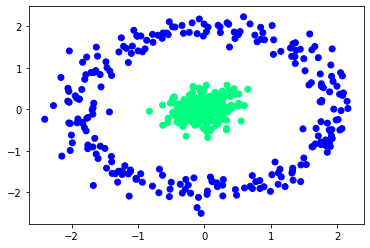

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_data(output, ax)

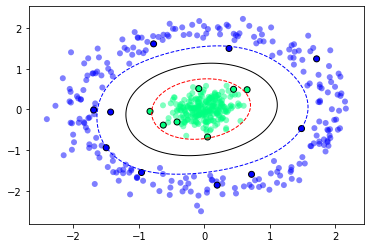

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

#**Ejemplo** (Kernel Polinomial)

In [0]:
X_train, y = make_moons(n_samples=500, noise=0.1,
                        random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [0]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, lambda x, y: gaussian_kernel(x, y, sigma=0.5),
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error


In [0]:
output = train(model)
output.alphas[output.alphas > 0]

array([1.        , 0.67672406, 1.        , 0.5562193 , 1.        ,
       0.34345942, 0.95382476, 0.65583869, 1.        , 1.        ,
       0.47701226, 1.        , 0.03970372, 0.48836442, 1.        ,
       0.22165247, 0.41344639, 0.86148816, 1.        , 1.        ,
       0.09514039, 1.        , 0.49663446, 0.24783488, 0.55611725,
       1.        , 0.79038992, 0.32242119, 1.        , 0.61266427,
       1.        , 0.91215013, 0.16931411, 0.14538143, 1.        ,
       0.58083137])

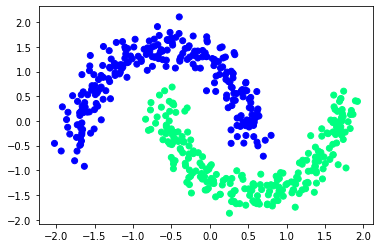

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_data(output, ax)

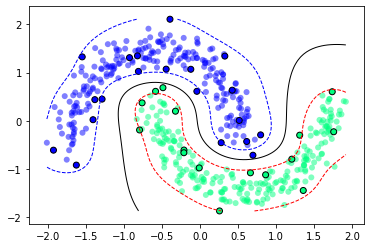

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [0]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model2 = SMOModel(X_train_scaled, y, C, lambda x, y: polynomial_kernel(x, y, degree=3),
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model2.alphas, model2.y, model2.kernel,
                                  model2.X, model2.X, model2.b) - model2.y
model2.errors = initial_error

In [0]:
output2 = train(model2)
output2.alphas[output2.alphas > 0]

array([1.        , 1.        , 1.        , 0.43770031, 1.        ,
       0.89013934, 0.31258942, 1.        , 0.82792496, 0.60740918,
       0.8914584 , 0.8658156 , 0.9223201 , 1.        , 0.02248096,
       0.09320088, 1.        , 1.        ])

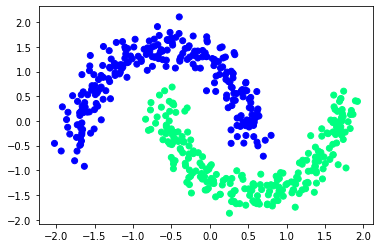

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_data(output2, ax)

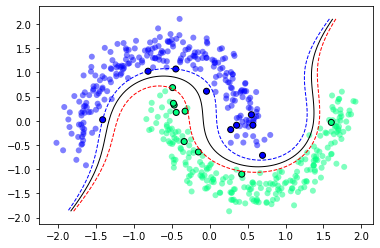

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output2, ax)

# **Ejemplo XOR** (Diapositivas de la clase)

In [0]:
X_train = np.array([(-1,-1),(1,-1),(-1,1),(1,1)])
y = np.array([1,-1,-1,1])
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

In [0]:
# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, lambda x, y: gaussian_kernel(x, y, sigma=0.5),
                 initial_alphas, initial_b, np.zeros(m))
# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
model.errors = initial_error

In [0]:
output = train(model)
output.alphas[output.alphas > 0]

array([1., 1., 1., 1.])

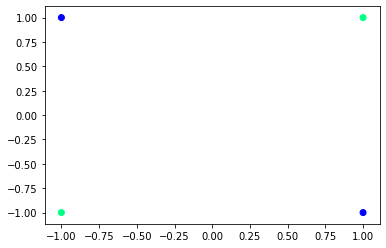

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_data(output, ax)

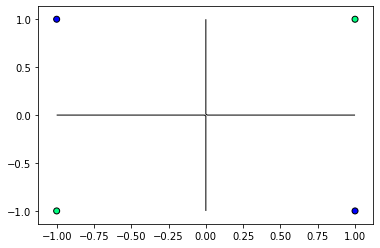

In [0]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)